In [1]:
from PIL import Image
import math
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 1. Image denoising 

In [2]:
img = Image.open('Image/lena.bmp').convert('L')
img = np.array(img)
h,w = img.shape

# 1) Generate the following noises, and add them to the ground-truth images.
# a) Impulse noise
def ImpulseNoiseImage(M,N,p):
    noise_img = np.zeros((M,N))
    for i in range(M):
        for j in range(N):
            t = np.random.uniform(0,1)
            if t < p/2 :
                noise_img[i][j] = -255
            elif t >= p/2 and t<p:
                noise_img[i][j] = 255
    return noise_img

# noise Image
I_noise = ImpulseNoiseImage(h,w,0.3)
# noise Added Imasge
INoiseAddedImage = I_noise + img
INoiseAddedImage = np.clip(INoiseAddedImage,0,255)

# b) Gaussian noise
def GaussianNoiseImage(M,N,std):
    noise_img = np.random.normal(0, std, (M,N))  # mean, std, shape
    return noise_img

# noise Image
G_noise = GaussianNoiseImage(h,w,30)
# noise Added Imasge
GNoiseAddedImage = G_noise + img

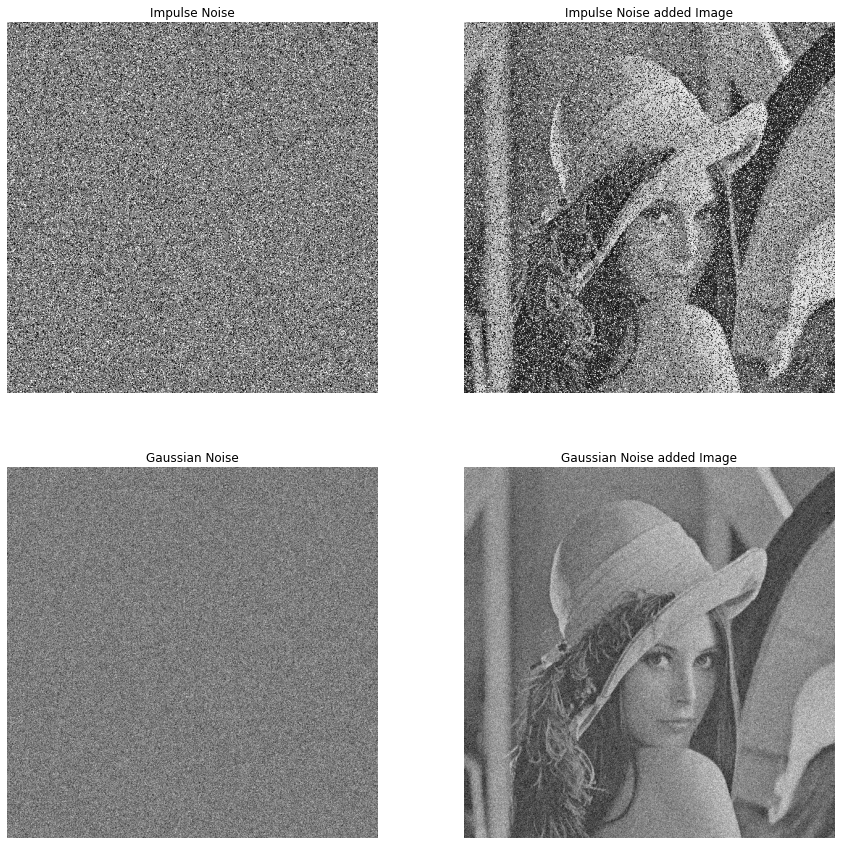

In [3]:
plt.figure(figsize=(15,15))
plt.subplot(2,2,1)
plt.axis('off')
plt.title('Impulse Noise')
plt.imshow(I_noise, cmap='gray')
plt.subplot(2,2,3)
plt.axis('off')
plt.title('Gaussian Noise')
plt.imshow(G_noise, cmap='gray')
plt.subplot(2,2,2)
plt.axis('off')
plt.title('Impulse Noise added Image')
plt.imshow(INoiseAddedImage, cmap='gray')
plt.subplot(2,2,4)
plt.axis('off')
plt.title('Gaussian Noise added Image')
plt.imshow(GNoiseAddedImage, cmap='gray')

In [4]:
# 2) Compute PSNR between ground-truth and noisy image.
def PSNR(img1, img2):
    mse = ((img1-img2)**2).mean()
    psnr = 10*math.log10(255**2 / mse )
    return psnr

G_noise30 = GaussianNoiseImage(h,w,30)
G_noise10 = GaussianNoiseImage(h,w,10)

GNoise30AddedImage = G_noise30 + img
GNoise10AddedImage = G_noise10 + img

I_noise03 = ImpulseNoiseImage(h,w,0.3)
INoise03AddedImage = I_noise03 + img
INoise03AddedImage = np.clip(INoise03AddedImage,0,255)

I_noise01 = ImpulseNoiseImage(h,w,0.1)
INoise01AddedImage = I_noise01 + img
INoise01AddedImage = np.clip(INoise01AddedImage,0,255)

print("GNoise(std=30) Added Image's PSNR: ", PSNR(img,GNoise30AddedImage))
print("GNoise(std=10) Added Image's PSNR: ", PSNR(img,GNoise10AddedImage))
print("INoise(p = 0.3)  Added Image's PSNR: ", PSNR(img,INoise03AddedImage))
print("INoise(p = 0.1) Added Image's PSNR: ", PSNR(img,INoise01AddedImage))

GNoise(std=30) Added Image's PSNR:  18.566403489612867
GNoise(std=10) Added Image's PSNR:  28.136125130311534
INoise(p = 0.3)  Added Image's PSNR:  10.658944708899469
INoise(p = 0.1) Added Image's PSNR:  15.41563572524221


In [5]:
# 3) Implement the following denoising filters, and apply them for denoising.
def filtering(img, filter):   
    h, w = img.shape
    fSize = len(filter)       # filter Size
    pSize = (fSize-1) // 2    # padding Size
    
    img = np.pad(img, ((pSize,pSize),(pSize,pSize)), 'constant', constant_values=0)
    filteredImg = np.zeros((h,w))
    
    for i in range(pSize,h+pSize):      # operate on ground-truth pixel
        for j in range(pSize,w+pSize):
            product = img[i-pSize:i+pSize+1,j-pSize:j+pSize+1] * filter
            filteredImg[i-pSize][j-pSize] = product.sum()
            
    return filteredImg

In [6]:
# a) Gaussian filter
def gaussianFilter(size, std):
    gfilter = np.zeros((size,size))
    offset = size // 2
    for i in range(-offset,offset+1):
        for j in range(-offset,offset+1):
            gfilter[i+offset][j+offset] = math.exp( -1 * ( i**2 + j**2 ) / (2*(std**2)) )
    return gfilter / gfilter.sum()

GFilter3x3 = gaussianFilter(7, 5)
GFilteredImage = filtering(GNoiseAddedImage, GFilter3x3)

In [7]:
# b) Bilateral filter
def bilateralFilter(image, x, y, size, std):   # 이미지, 픽셀위치, 필터 크기, 분산
    kernel = np.zeros((size,size),dtype='float')
    offset = size // 2
    for i in range(-offset, offset+1):
        for j in range(-offset, offset+1):
            kernel[i+offset][j+offset] =  math.exp( -1 * (image[x][y]-image[x+i][y+j])**2 / ( 2* std**2) ) * \
                                            math.exp( -1 * ( i**2 + j**2 ) / ( 2 * std**2) ) 
    return kernel / kernel.sum()

# padding
kernel_size=5
pSize= kernel_size //2
pimg = np.pad(img, ((pSize,pSize),(pSize,pSize)), 'constant', constant_values=0)

# 이미지의 각 픽셀에 대한 커널 생성 및 filtering
BFilteredImage = np.zeros((h,w))
for i in range(pSize,h+pSize):
    for j in range(pSize,w+pSize):
        BFilter = bilateralFilter(pimg,i,j,5,5)
        product = pimg[i-pSize:i+pSize+1,j-pSize:j+pSize+1] * BFilter
        BFilteredImage[i-pSize][j-pSize] = product.sum()

c:\users\jaehyeon\anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in ubyte_scalars
  import sys


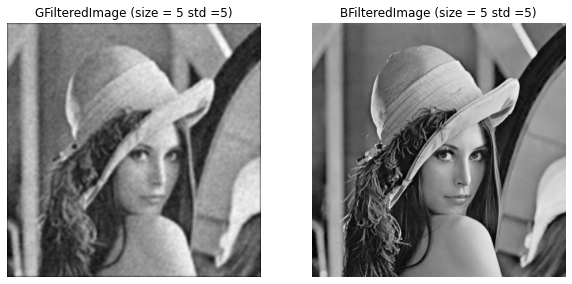

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('GFilteredImage (size = 5 std =5)')
plt.axis('off')
plt.imshow(GFilteredImage, cmap='gray')
plt.subplot(1,2,2)
plt.title('BFilteredImage (size = 5 std =5)')
plt.axis('off')
plt.imshow(BFilteredImage, cmap='gray')

In [9]:
# 4) Please compare and analyze the results with subjective and objective (PSNR) measurements.
print('Gaussian Filteed Image VS Ground-Truth: ', PSNR(img,GFilteredImage))
print('Bilateral Filteed Image VS Ground-Truth: ', PSNR(img,BFilteredImage))

Gaussian Filteed Image VS Ground-Truth:  26.03014280488154
Bilateral Filteed Image VS Ground-Truth:  40.78087502510932
